In [1]:
import Dates
println("Last updated: ", Dates.now())

Last updated: 2020-07-14T23:25:15.446


In [2]:
# Load environment
import Pkg; Pkg.activate("../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [3]:
# Import Libraries
using Turing
using Turing: Variational
using Turing.RandomMeasures: stickbreak
using Distributions
using JSON3
using PyPlot
using StatsFuns
import Random
using BenchmarkTools
using Flux
import LinearAlgebra

In [138]:
function neural_net(x, w1, b1, w2, b2)
    z = sigmoid.(x * w1 .+ b1)
    return z * w2 .+ b2
end

# d1 = Dense(randn(5, 2), randn(5, 1), sigmoid)
# d2 = Dense(randn(1, 5), randn(1, 1), sigmoid)
# c = Chain(d1, d2)
# c(randn(2, 100))

# neural_net(randn(10, 2), randn(2, 5), randn(1, 5), randn(5,1), randn(1, 1))
# neural_net(randn(10, 2), randn(2, 5), randn(1, 5), randn(5,2), randn(1, 2))

neural_net (generic function with 1 method)

In [5]:
function bivnormlogpdf(x, m, S)
    K = length(m)
    invS = inv(S)
    z = (x - m)
    log_numer = -z' * invS * z / 2
    log_denom = 0.5 * (K * log(2*pi) + LinearAlgebra.logdet(S))
    return sum(log_numer) - log_denom
end

eye(n::Int) = Matrix{Float64}(LinearAlgebra.I, n, n);

In [6]:
function make_cov(sigx, sigy, rho)
    c = sigx * sigy * rho
    sx2 = sigx*sigx
    sy2 = sigy*sigy
    return reshape([sx2, c, c, sy2], 2, 2)
end

# inv(make_cov(rand()*2, rand()*2, rand()*2 - 1))

make_cov (generic function with 1 method)

In [7]:
struct MvGMM <: ContinuousMultivariateDistribution
    mu::Matrix{Float64}
    # Sigma::Array{Float64, 3} 
    Sigma::Vector{Matrix{Float64}}
    w::Vector{Float64}
end

In [29]:
function Distributions.rand(rng::Random.AbstractRNG, d::MvGMM)
    D, K = size(d.mu)  # dimension x num_components
    k = rand(Categorical(d.w)) 
    rand(MvNormal(d.mu[:, k], d.Sigma[k]))
end

function Distributions.logpdf(d::MvGMM, x::AbstractVector{<:Real})
    D, K = size(d.mu)  # dimension x num_components
    ll = [logpdf(MvNormal(d.mu[:, k], d.Sigma[k]), x) for k in 1:K]
    return logsumexp(ll .+ log.(d.w))
end

Bijectors.bijector(d::MvGMM) = Identity{1}()

# Example:
# Sigma = [make_cov(.5, .5, .5) for _ in 1:5]
# mvgmm = MvGMM(randn(2,5), Sigma, stickbreak(rand(4)))
# x = rand(mvgmm)
# logpdf(mvgmm, x)

In [56]:
# DP GMM model under stick-breaking construction
# FIXME: Look at the very round-about way to do NN below.
@model function warped_mixture_2D(Y, K, P, ::Type{T}=Matrix{Float64}) where T
    nobs, D = size(Y)

    # Mixture weights.
    alpha ~ Uniform(0, 1)
    v ~ filldist(Beta(1, alpha), K - 1)
    eta = stickbreak(v)
    
    # Neural net parameters.
    w1 ~ filldist(Normal(0, 1), D, P)
    b1 ~ filldist(Normal(0, 1), 1, P)
    w2 ~ filldist(Normal(0, 1), P, D)
    b2 ~ filldist(Normal(0, 1), 1, D)    
    
    # Mixture parameters
    mu ~ filldist(Normal(0, 1), D, K)
    R11 ~ filldist(LogNormal(0, 1), K)
    R22 ~ filldist(LogNormal(0, 1), K)
    rho ~ filldist(Uniform(-1, 1), K)
    R = make_cov.(R11, R22, rho)
    sigma ~ LogNormal(-1, 1)

    # Latent variables.
    x = T(undef, nobs, D)
    for i in 1:nobs
        x[i, :] ~ MvGMM(mu, R, eta)
    end
    
    # Latent variables.
    z = neural_net(x, w1, b1, w2, b2)
    
    Turing.acclogp!(_varinfo, sum(normlogpdf.(z, sigma, Y)))
end

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /home/ubuntu/.julia/packages/DynamicPPL/MRwtL/src/compiler.jl:181


DynamicPPL.ModelGen{var"###generator#1045",(:Y, :K, :P, :T),(:T,),Tuple{Type{Array{Float64,2}}}}(##generator#1045, NamedTuple{(:T,),Tuple{Type{Array{Float64,2}}}}((Array{Float64,2},)))

In [57]:
Y = randn(100, 2)
m = warped_mixture_2D(Y, 10, 20)  # data, num_components, nn_num_units
q0 = Variational.meanfield(m)  # initialize variational distribution (optional)
# advi = ADVI(1, 2000)  # num_elbo_samples, max_iters
# @time q = vi(m, advi, q0, optimizer=Flux.ADAM(1e-2));

DimensionMismatch: DimensionMismatch("A has dimensions (2,1) but B has dimensions (2,20)")

In [205]:
function unpack(θ::AbstractVector, network_shape::AbstractVector)
    index = 1
    weights = []
    biases = []
    for layer in network_shape
        rows, cols, _ = layer
        size = rows * cols
        last_index_w = size + index - 1
        last_index_b = last_index_w + rows
        push!(weights, reshape(θ[index:last_index_w], rows, cols))
        push!(biases, reshape(θ[last_index_w+1:last_index_b], rows))
        index = last_index_b + 1
    end
    return weights, biases
end
function nn_forward(x, θ::AbstractVector, network_shape::AbstractVector)
    weights, biases = unpack(θ, network_shape)
    layers = []
    for i in eachindex(network_shape)
        push!(layers, Dense(weights[i],
            biases[i],
            eval(network_shape[i][3])))
    end
    nn = Chain(layers...)
    return nn(x)
end

network_shape = [(7, 2, :σ), (2, 7, :σ)]
x = randn(2, 10)
num_params = sum([i * o + i for (i, o, _) in network_shape])
theta = randn(num_params)
nn_forward(x, theta, network_shape)

2×10 Array{Float64,2}:
 0.956156   0.948677  0.975518   0.99039    …  0.973304   0.949869  0.983026
 0.0782339  0.135379  0.0869439  0.0755955     0.0890644  0.133626  0.0656832

In [236]:
@model function bnn(y, X, num_units) where T
    nobs, P = size(X)
    network_shape = [(num_units, P, :tanh), (1, num_units, :tanh)]
    num_params = sum([i * o + i for (i, o, _) in network_shape])
    
    # Neural net parameters.
    nn_params ~ filldist(Normal(0, 1), num_params)
    
    # Latent variables.
    z = nn_forward(X', nn_params, network_shape)
    
    # Model noise
    sigma ~ LogNormal(-1, 1)
   
    # Turing.acclogp!(_varinfo, sum(normlogpdf.(z, sigma, y)))
    y ~ MvNormal(vec(z), sigma * eye(nobs))
end

DynamicPPL.ModelGen{var"###generator#1953",(:y, :X, :num_units),(),Tuple{}}(##generator#1953, NamedTuple())

[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:01:50


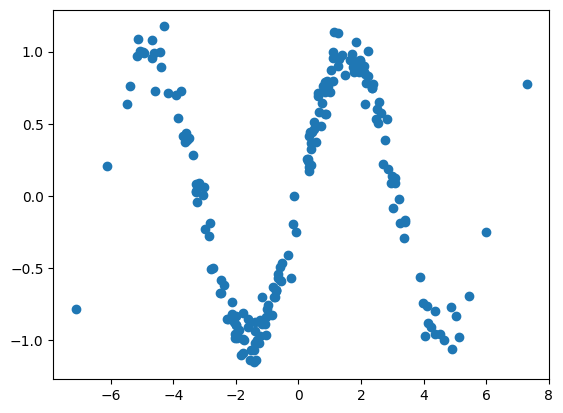

110.930964 seconds (5.34 M allocations: 81.013 GiB, 6.97% gc time)


In [260]:
N = 200
X = randn(N, 1) * 3
y = sin.(vec(X)) + randn(N) * 0.1
plt.scatter(vec(X), y)
m = bnn(y, X, 5)  # data, num_components, nn_num_units
q0 = Variational.meanfield(m)  # initialize variational distribution (optional)
advi = ADVI(1, 2000)  # num_elbo_samples, max_iters
@time q = vi(m, advi, q0, optimizer=Flux.ADAM(1e-1));

In [264]:
function quantiles(X, q; dims, drop=false)
  Q = mapslices(x -> quantile(x, q), X, dims=dims)
  out = drop ? dropdims(Q, dims=dims) : Q
  return out
end

quantiles (generic function with 1 method)

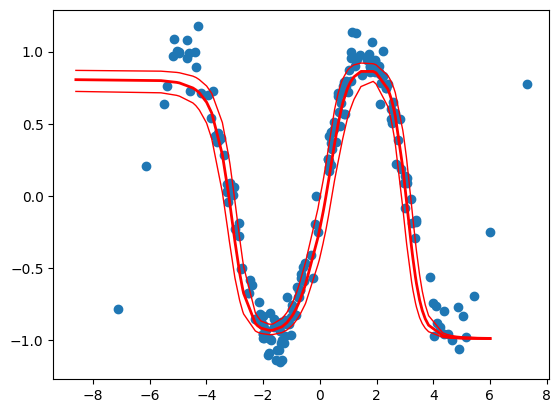

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fde4fd9b160>

In [271]:
nsamples = 1000
iqsamples = rand(q, nsamples)
_, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
extract(sym) = qsamples[collect(sym2range[sym][1]), :]

nn_params = extract(:nn_params)
num_units=5
network_shape = [(num_units, 1, :tanh), (1, num_units, :tanh)]
num_params = sum([i * o + i for (i, o, _) in network_shape])
x = sort(randn(100, 1) * 3, dims=1)
preds = [nn_forward(x', nn_params[:, i], network_shape) for i in 1:nsamples]
preds = vcat(preds...)

plt.scatter(vec(X), y)
plt.plot(x, vec(quantiles(preds, 0.975, dims=1)), color="red", lw=1)
plt.plot(x, vec(mean(preds, dims=1)), color="red", lw=2)
plt.plot(x, vec(quantiles(preds, 0.025, dims=1)), color="red", lw=1)